# Apply expected path development to time-series classification
**Data :**
*ItalyPowerDemand* from [UAE](https://www.timeseriesclassification.com/description.php?Dataset=ItalyPowerDemand)


In [18]:
import os
from aeon.datasets import load_from_tsfile
from matplotlib import pyplot as plt

In [66]:
data_dir = os.path.join(os.getcwd(), "..", "data", "ItalyPowerDemand")
train_file = "ItalyPowerDemand_TRAIN.ts"
test_file = "ItalyPowerDemand_TEST.ts"

In [67]:
tsx_train, y_train = load_from_tsfile(os.path.join(data_dir, train_file))
tsx_test, y_test = load_from_tsfile(os.path.join(data_dir, test_file))
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Show time series 

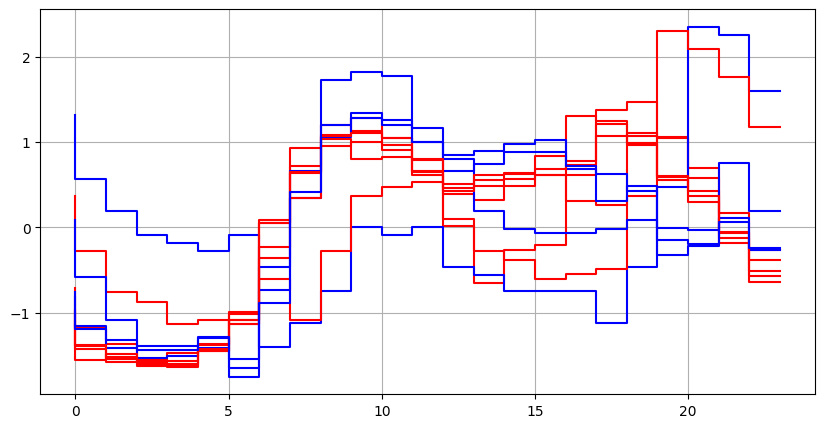

In [68]:
cm = {1: "red", 2: "blue"}
_, ax = plt.subplots(figsize=(10, 5))
x = range(24)
for i in range(10):
    ax.step(x, tsx_train[i, 0, :], c=cm[y_train[i]])
ax.grid()

## Benchmark
Logistic regression considering tabular data instead of time-series

In [ ]:
import numpy
from sklearn.metrics import confusion_matrix

In [69]:
X = tsx_train[:, 0, :]
X_test = tsx_test[:, 0, :]
X.shape

(67, 24)

In [70]:
from sklearn.linear_model import LogisticRegression

In [71]:
model = LogisticRegression()
model.fit(X, y_train)
y_hat_train = model.predict(X)
y_hat = model.predict(X_test)

LogisticRegression()

In [271]:
confusion_matrix(y_hat, y_test)

array([[500,  23],
       [ 13, 493]], dtype=int64)

In [73]:
np.sum(y_train == y_hat_train) / len(y_train), np.sum(y_test == y_hat) / len(y_test)

(0.9850746268656716, 0.9650145772594753)

In [75]:
# local imports
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

from development.nn import development_layer
from development.so import so

In [76]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
from torch import optim
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd

In [77]:
# time augmentation
tsx_train = np.concatenate(
    [tsx_train, np.repeat(np.array([np.array([list(range(24))])]), len(tsx_train), axis=0)], axis=1
)
tsx_test = np.concatenate(
    [tsx_test, np.repeat(np.array([np.array([list(range(24))])]), len(tsx_test), axis=0)], axis=1
)

# series dimension last
tsx_train = Tensor(tsx_train).swapaxes(1, 2)
tsx_test = Tensor(tsx_test).swapaxes(1, 2)

y_train = Tensor(y_train)
y_test = Tensor(y_test)

## Train

In [112]:
# build the dataset
batch_size = 35
# batch_size = 23
train = TensorDataset(tsx_train, y_train)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

torch.Size([67, 24, 2])

In [199]:
def train_model(
    model,
    optimizer,
    data_loader,
    hidden_size: int,
    num_epochs=10,
    alpha=0.5,
    beta=0.2,
    verbose=True,
):
    model.train()
    lossx = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            X = model(inputs)

            Y = X[labels == 1]
            Z = X[labels == 2]

            tau_y = torch.mean(Y, axis=0)
            tau_z = torch.mean(Z, axis=0)
            dtau = tau_y - tau_z
            dtauy = tau_y - Y
            dtauz = tau_z - Z
            loss = (
                -(dtau[0].T.matmul(dtau[0]).diagonal(dim1=0, dim2=1).sum(-1)) / hidden_size
                - beta
                * (dtau[0].T.matmul(dtau[0]).diagonal(dim1=0, dim2=1).sum(-1)) ** 2
                / hidden_size
                + alpha
                * torch.norm(
                    torch.swapaxes(dtauy[:, 0, ...], 1, 2)
                    .bmm(dtauy[:, 0, ...])
                    .diagonal(dim1=1, dim2=2)
                    .sum(-1)
                )
                ** 2
                / hidden_size
                / len(dtauy)
                + alpha
                * torch.norm(
                    torch.swapaxes(dtauz[:, 0, ...], 1, 2)
                    .bmm(dtauz[:, 0, ...])
                    .diagonal(dim1=1, dim2=2)
                    .sum(-1)
                )
                ** 2
                / hidden_size
                / len(dtauz)
            )
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        lossx.append(running_loss / len(data_loader))
        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(data_loader)}")

    return lossx

In [255]:
# try diferent sizes and groups and channels

hidden_size = 4
dev_layer = development_layer(
    input_size=2,
    hidden_size=hidden_size,
    channels=1,
    param=so,
    complexification=False,
    return_sequence=False,
)

Epoch [1/250], Loss: 0.7464469869931539
Epoch [2/250], Loss: 0.592940886815389
Epoch [3/250], Loss: 0.932297945022583
Epoch [4/250], Loss: 0.7620091438293457
Epoch [5/250], Loss: 0.5604767501354218
Epoch [6/250], Loss: 0.6161185503005981
Epoch [7/250], Loss: 0.519665390253067
Epoch [8/250], Loss: 0.7995950281620026
Epoch [9/250], Loss: 0.7288070122400919
Epoch [10/250], Loss: 0.546847383181254
Epoch [11/250], Loss: 0.6078466375668844
Epoch [12/250], Loss: 0.7445165316263834
Epoch [13/250], Loss: 0.6835518081982931
Epoch [14/250], Loss: 0.4729272921880086
Epoch [15/250], Loss: 0.4302978217601776
Epoch [16/250], Loss: 0.619341770807902
Epoch [17/250], Loss: 0.6936975916226705
Epoch [18/250], Loss: 0.5209393898646036
Epoch [19/250], Loss: 0.5661093990008036
Epoch [20/250], Loss: 0.500787635644277
Epoch [21/250], Loss: 0.46737585465113324
Epoch [22/250], Loss: 0.22576475143432617
Epoch [23/250], Loss: -0.25539396206537884
Epoch [24/250], Loss: -0.061644017696380615
Epoch [25/250], Loss: 0.

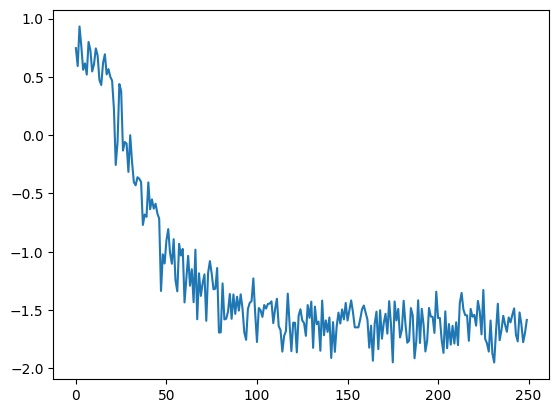

In [256]:
optimizer = optim.Adam(dev_layer.parameters(), lr=0.0008)

lossx = train_model(
    dev_layer, optimizer, train_loader, hidden_size, num_epochs=250, alpha=0.5, beta=0.5
)
_, ax = plt.subplots()
plt.plot(range(len(lossx)), lossx)

## Test

In [257]:
dev_train = dev_layer(tsx_train)
dev_test = dev_layer(tsx_test)

In [258]:
dev_test.shape

torch.Size([1029, 1, 4, 4])

In [259]:
dt1 = dev_train[y_train == 1][:, 0, ...]
dt2 = dev_train[y_train == 2][:, 0, ...]

In [260]:
tau1 = torch.mean(dt1, axis=0)
tau2 = torch.mean(dt2, axis=0)

In [261]:
ddt1 = dt1 - tau1
ddt2 = dt2 - tau2
ddt12 = dt1[:-1] - dt2

In [263]:
diff1 = (dev_train - tau1)[:, 0, ...]
diff2 = (dev_train - tau2)[:, 0, ...]

dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

c = (dd1 > dd2).detach().numpy().astype(float) + 1

In [265]:
confusion_matrix(y_train.numpy(), c)

array([[34,  0],
       [ 1, 32]], dtype=int64)

In [266]:
(y_train == c).sum() / len(y_train)

tensor(0.9851)

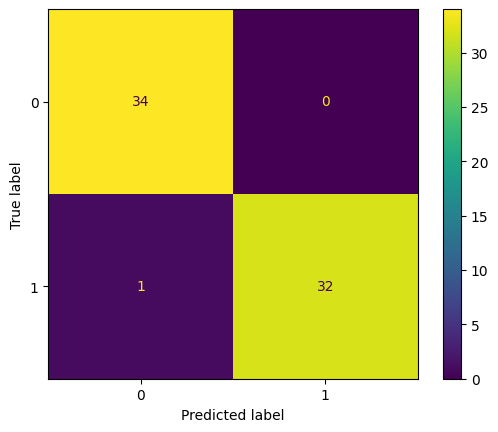

In [267]:
ConfusionMatrixDisplay(confusion_matrix(y_train.numpy(), c)).plot()

In [268]:
diff1 = (dev_test - tau1)[:, 0, ...]
diff2 = (dev_test - tau2)[:, 0, ...]

dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
(y_test.numpy() == c_test).sum() / len(y_test)

0.9582118561710399

no overfitting

In [184]:
confusion_matrix(y_test.numpy(), c_test)

array([[500,  13],
       [ 30, 486]], dtype=int64)

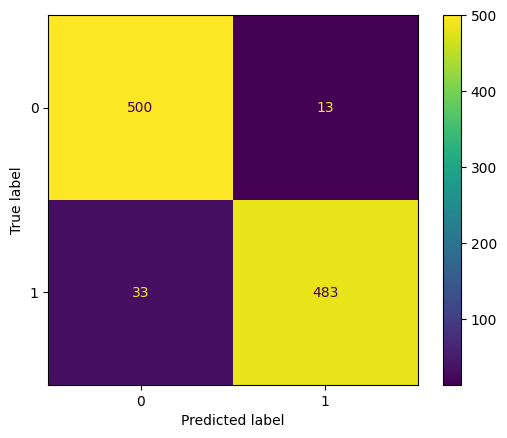

In [109]:
ConfusionMatrixDisplay(confusion_matrix(y_test.numpy(), c_test)).plot()

In [27]:
def hilbert_schmidt_distance(d1, d2):
    d = d1 - d2
    return d.T.matmul(d).diagonal().sum()

In [1067]:
def hilbert_schmidt_distance_np(d1, d2):
    d1 = Tensor(d1).reshape(hidden_size, hidden_size)
    d2 = Tensor(d2).reshape(hidden_size, hidden_size)
    d = d1 - d2
    return d.T.matmul(d).diagonal().sum()

In [1068]:
X = dev_train.reshape(len(dev_train), -1).detach().numpy()

In [ ]:
_, axs = plt.subplots(nrows=2, ncols=8, figsize=(12, 4))
for i in range(8):
    axs[0, i].imshow(dev_train[y_train == 1][i, 0, ...].detach().numpy())
    axs[1, i].imshow(dev_train[y_train == 2][i, 0, ...].detach().numpy())

In [1112]:
torch.save(dev_layer.state_dict(), os.path.join(os.getcwd(), "pdev_ItalyPowerDemand"))

## Compare expected signature

In [7]:
import signatory

In [27]:
depth = 2
sig_train = signatory.signature(tsx_train, depth=depth)

# the embedding is parameter-free
esig1 = torch.mean(sig_train[y_train == 1], axis=0)
esig2 = torch.mean(sig_train[y_train == 2], axis=0)

In [ ]:
len(esig1)

In [29]:
def tensor_inner_product_level(t1k: Tensor, t2k: Tensor, n: int, k: int, d: int) -> Tensor:
    t1k = t1k.reshape((n, d, 2 ** (k - 1)))
    t2k = t2k.reshape((n, d, 2 ** (k - 1)))
    return (t1k * t2k).sum(dim=1).prod(dim=1)


def batched_tensor_inner_product(t1: Tensor, t2: Tensor, d: int, depth: int) -> Tensor:
    batch_size = t1.size(0)
    assert t1.size(0) == t2.size(0)
    p = torch.zeros(batch_size)
    for k in range(1, depth):
        t1k = signatory.extract_signature_term(t1, d, k)
        t2k = signatory.extract_signature_term(t2, d, k)
        p += tensor_inner_product_level(t1k, t2k, batch_size, k, d)
    return p

In [ ]:
dsig1 = sig_train - esig1
dsig2 = sig_train - esig2

ddsig1 = batched_tensor_inner_product(dsig1, dsig1, 2, depth)
ddsig2 = batched_tensor_inner_product(dsig2, dsig2, 2, depth)

c = (ddsig1 > ddsig2).detach().numpy().astype(float) + 1
c

In [ ]:
confusion_matrix(y_train, c)

In [ ]:
(y_train == c).sum().numpy() / len(y_train)

In [ ]:
accuracyx = []
for depth in range(2, 10):
    sig_train = signatory.signature(tsx_train, depth=depth)

    # the embedding is parameter-free
    esig1 = torch.mean(sig_train[y_train == 1], axis=0)
    esig2 = torch.mean(sig_train[y_train == 2], axis=0)
    dsig1 = sig_train - esig1
    dsig2 = sig_train - esig2

    ddsig1 = batched_tensor_inner_product(dsig1, dsig1, 2, depth)
    ddsig2 = batched_tensor_inner_product(dsig2, dsig2, 2, depth)

    c = (ddsig1 > ddsig2).detach().numpy().astype(float) + 1
    print(confusion_matrix(y_train, c))
    accuracyx.append((y_train == c).sum().numpy() / len(y_train))

In [ ]:
plt.bar(range(2, 10), accuracyx, ylabel="Accurary")

## Influence of the hidden size

In [ ]:
# try diferent sizes and groups and channels
hx = range(2, 11)
res = pd.DataFrame(index=hx, columns=["Train", "Test"])

for h in hx:
    print("\n")
    print("#####################################")
    print(f">>> Hidden size = {h}")
    print("#####################################")
    dev_layer = development_layer(
        input_size=2,
        hidden_size=h,
        channels=1,
        param=so,
        complexification=False,
        return_sequence=False,
    )
    optimizer = optim.Adam(dev_layer.parameters(), lr=0.001)
    lossx = train_model(dev_layer, optimizer, train_loader, num_epochs=300, verbose=False)
    _, ax = plt.subplots()
    ax.plot(range(len(lossx)), lossx)
    ax.set_title(f"Loss hidden_size={h}")
    ax.set_xlabel("n epoch")
    ax.legend()
    ax.grid()
    # ax.show()
    dev_train = dev_layer(tsx_train)
    dev_test = dev_layer(tsx_test)

    dt1 = dev_train[y_train == 1][:, 0, ...]
    dt2 = dev_train[y_train == 2][:, 0, ...]

    tau1 = torch.mean(dt1, axis=0)
    tau2 = torch.mean(dt2, axis=0)

    # train
    ddt1 = dt1 - tau1
    ddt2 = dt2 - tau2
    ddt12 = dt1[:-1] - dt2

    diff1 = (dev_train - tau1)[:, 0, ...]
    diff2 = (dev_train - tau2)[:, 0, ...]

    dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
    dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

    c = (dd1 > dd2).detach().numpy().astype(float) + 1

    ConfusionMatrixDisplay(confusion_matrix(y_train.numpy(), c)).plot()  # title=f"Hidden size={h}"
    actrain = (y_train == c).sum().numpy() / len(y_train)
    print(h, f"Train accuracy={actrain}")

    # test
    diff1 = (dev_test - tau1)[:, 0, ...]
    diff2 = (dev_test - tau2)[:, 0, ...]

    dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
    dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

    c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
    actest = (y_test.numpy() == c_test).sum() / len(y_test)
    res.loc[h] = [actrain, actest]
    print(h, f"Test accuracy={actest}")

    ConfusionMatrixDisplay(
        confusion_matrix(y_test.numpy(), c_test)
    ).plot()  # title=f"Test, hidden_size={h}"

In [ ]:
res.apply(lambda col: np.round(col, decimals=2))

In [60]:
res.round(0)  # .style.format(".2f")

,Train,Test
2,0.522388,0.559767
3,0.985075,0.947522
4,0.985075,0.951409
5,0.970149,0.94655
6,0.970149,0.956268
7,0.985075,0.962099
8,0.970149,0.94655
9,0.970149,0.954325
10,0.970149,0.959184


In [65]:
res.astype(float).round(3) * 100

,Train,Test
2,52.2,56.0
3,98.5,94.8
4,98.5,95.1
5,97.0,94.7
6,97.0,95.6
7,98.5,96.2
8,97.0,94.7
9,97.0,95.4
10,97.0,95.9


## Influence of the group

In [67]:
from development.se import se
from development.sp import sp



#####################################
>>> Param = so
#####################################


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


so Train accuracy=0.9850746268656716
so Test accuracy=0.9620991253644315


#####################################
>>> Param = sp
#####################################


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sp Train accuracy=0.9253731343283582
sp Test accuracy=0.9203109815354713


#####################################
>>> Param = se
#####################################


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


se Train accuracy=0.9402985074626866
se Test accuracy=0.902818270165209


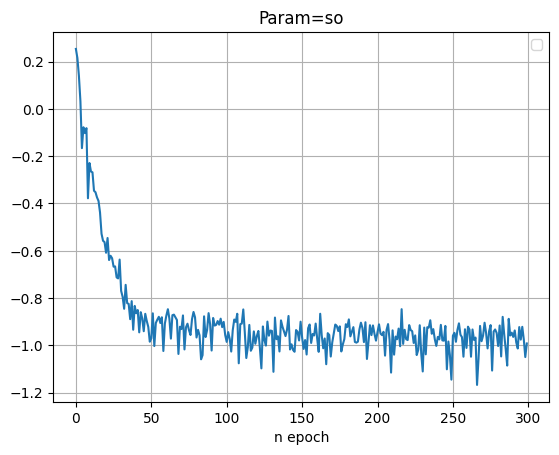

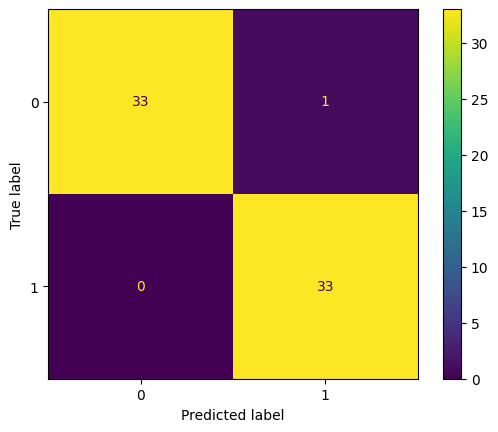

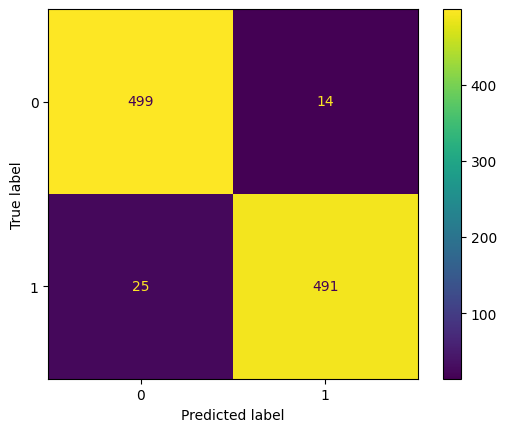

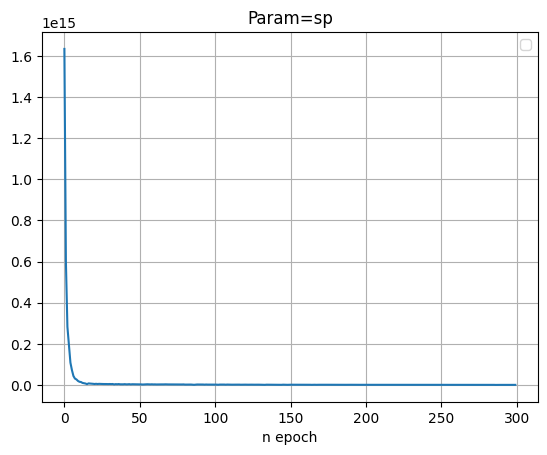

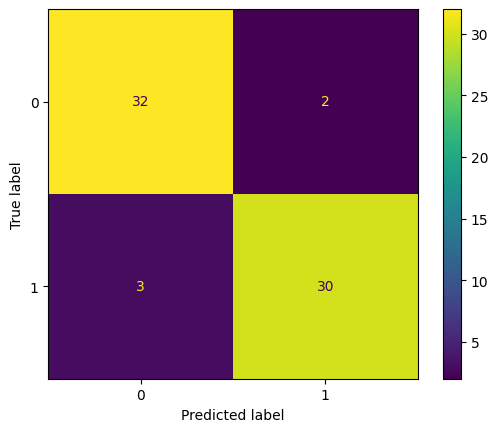

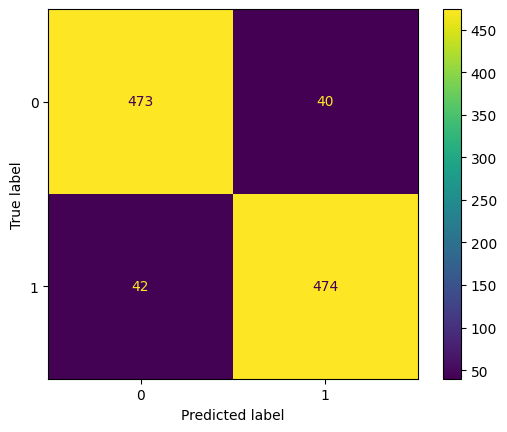

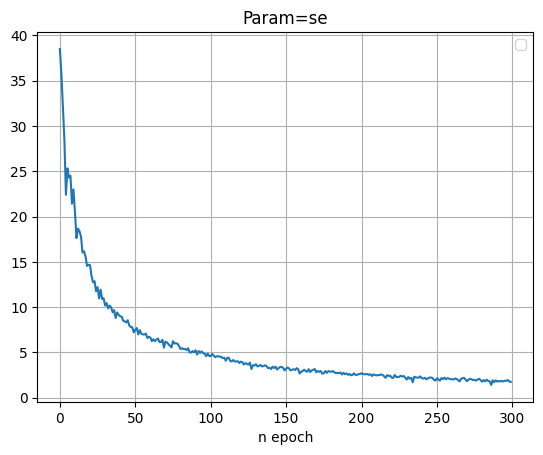

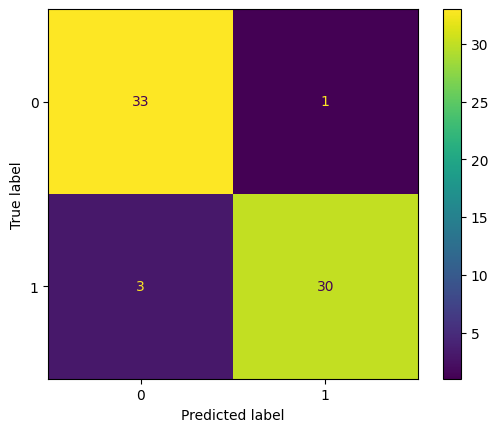

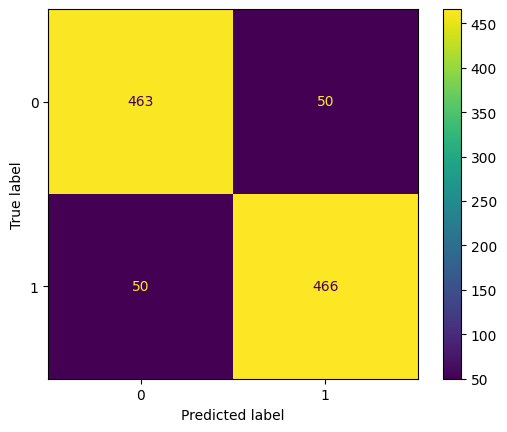

In [69]:
# try diferent sizes and groups and channels
paramx = [so, sp, se]
hidden_size = 6
res = pd.DataFrame(index=[p.__name__ for p in paramx], columns=["Train", "Test"])

for param in paramx:
    print("\n")
    print("#####################################")
    print(f">>> Param = {param.__name__}")
    print("#####################################")
    dev_layer = development_layer(
        input_size=2,
        hidden_size=hidden_size,
        channels=1,
        param=param,
        complexification=False,
        return_sequence=False,
    )
    optimizer = optim.Adam(dev_layer.parameters(), lr=0.001)
    lossx = train_model(dev_layer, optimizer, train_loader, num_epochs=300, verbose=False)
    _, ax = plt.subplots()
    ax.plot(range(len(lossx)), lossx)
    ax.set_title(f"Param={param.__name__}")
    ax.set_xlabel("n epoch")
    ax.legend()
    ax.grid()
    dev_train = dev_layer(tsx_train)
    dev_test = dev_layer(tsx_test)

    dt1 = dev_train[y_train == 1][:, 0, ...]
    dt2 = dev_train[y_train == 2][:, 0, ...]

    tau1 = torch.mean(dt1, axis=0)
    tau2 = torch.mean(dt2, axis=0)

    # train
    ddt1 = dt1 - tau1
    ddt2 = dt2 - tau2
    ddt12 = dt1[:-1] - dt2

    diff1 = (dev_train - tau1)[:, 0, ...]
    diff2 = (dev_train - tau2)[:, 0, ...]

    dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
    dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

    c = (dd1 > dd2).detach().numpy().astype(float) + 1

    ConfusionMatrixDisplay(confusion_matrix(y_train.numpy(), c)).plot()  # title=f"Hidden size={h}"
    actrain = (y_train == c).sum().numpy() / len(y_train)
    print(param.__name__, f"Train accuracy={actrain}")

    # test
    diff1 = (dev_test - tau1)[:, 0, ...]
    diff2 = (dev_test - tau2)[:, 0, ...]

    dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
    dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

    c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
    actest = (y_test.numpy() == c_test).sum() / len(y_test)
    res.loc[param.__name__] = [actrain, actest]
    print(param.__name__, f"Test accuracy={actest}")

    ConfusionMatrixDisplay(
        confusion_matrix(y_test.numpy(), c_test)
    ).plot()  # title=f"Test, hidden_size={h}"

In [73]:
res.astype(float).round(3) * 100

,Train,Test
so,98.5,96.2
sp,92.5,92.0
se,94.0,90.3


## Influence of the number of channels

In [429]:
def train_model_multichannels(
    model,
    optimizer,
    data_loader,
    hidden_size: int,
    num_epochs=10,
    alpha=0.5,
    beta=0.2,
    verbose=True,
):
    model.train()
    lossx = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            X = model(inputs)

            Y = X[labels == 1]
            Z = X[labels == 2]

            tau_y = torch.mean(Y, axis=0)
            tau_z = torch.mean(Z, axis=0)
            dtau = tau_y - tau_z
            dtauy = tau_y - Y
            dtauz = tau_z - Z
            b, c, d, _ = X.shape

            loss = (
                -(1 - beta)
                * (torch.swapaxes(dtau, 1, 2).bmm(dtau).diagonal(dim1=1, dim2=2).sum())
                / hidden_size
                / b
                - beta
                * (torch.swapaxes(dtau, 1, 2).bmm(dtau).diagonal(dim1=1, dim2=2).sum()) ** 2
                / hidden_size
                + alpha
                * torch.norm(
                    torch.swapaxes(dtauy.reshape((len(dtauy) * c, d, d)), 1, 2)
                    .bmm(dtauy.reshape((len(dtauy) * c, d, d)))
                    .diagonal(dim1=1, dim2=2)
                    .sum(-1)
                )
                ** 2
                / hidden_size
                / len(dtauy)
                + alpha
                * torch.norm(
                    torch.swapaxes(dtauz.reshape((len(dtauz) * c, d, d)), 1, 2)
                    .bmm(dtauz.reshape((len(dtauz) * c, d, d)))
                    .diagonal(dim1=1, dim2=2)
                    .sum(-1)
                )
                ** 2
                / hidden_size
                / len(dtauz)
            ) / c
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        lossx.append(running_loss / len(data_loader))
        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(data_loader)}")

    return lossx

In [458]:
# build the dataset
batch_size = 34
train = TensorDataset(tsx_train, y_train)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

In [499]:
hidden_size = 5
nchannels = 2
dev_layer = development_layer(
    input_size=2,
    hidden_size=hidden_size,
    channels=nchannels,
    param=so,
    complexification=False,
    return_sequence=False,
)

Epoch [1/200], Loss: -0.08003184199333191
Epoch [2/200], Loss: -0.18378861993551254
Epoch [3/200], Loss: -0.2871968746185303
Epoch [4/200], Loss: -0.112763412296772
Epoch [5/200], Loss: -0.1950264424085617
Epoch [6/200], Loss: -0.1270134598016739
Epoch [7/200], Loss: -0.2889517471194267
Epoch [8/200], Loss: -0.18382509052753448
Epoch [9/200], Loss: -0.2875862568616867
Epoch [10/200], Loss: -0.23604784905910492
Epoch [11/200], Loss: -0.43327222764492035
Epoch [12/200], Loss: -0.3676210641860962
Epoch [13/200], Loss: -0.2930762618780136
Epoch [14/200], Loss: -0.3099270164966583
Epoch [15/200], Loss: -0.3846771717071533
Epoch [16/200], Loss: -0.5284584015607834
Epoch [17/200], Loss: -0.4028678983449936
Epoch [18/200], Loss: -0.36354297399520874
Epoch [19/200], Loss: -0.3794637471437454
Epoch [20/200], Loss: -0.41754211485385895
Epoch [21/200], Loss: -0.4164985567331314
Epoch [22/200], Loss: -0.4773190766572952
Epoch [23/200], Loss: -0.4891466498374939
Epoch [24/200], Loss: -0.442008599638

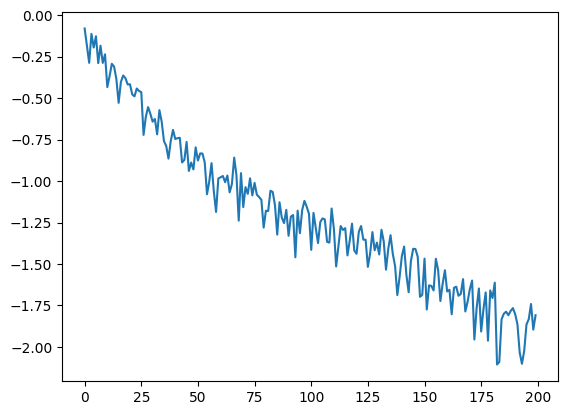

In [501]:
optimizer = optim.Adam(dev_layer.parameters(), lr=0.0005)

lossx = train_model_multichannels(
    dev_layer, optimizer, train_loader, hidden_size, num_epochs=200, alpha=0.5, beta=0.5
)
_, ax = plt.subplots()
plt.plot(range(len(lossx)), lossx)

In [502]:
dev_train = dev_layer(tsx_train)
dev_test = dev_layer(tsx_test)
dt1 = dev_train[y_train == 1]
dt2 = dev_train[y_train == 2]
tau1 = torch.mean(dt1, axis=0)
tau2 = torch.mean(dt2, axis=0)

diff1 = (dev_train - tau1).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff2 = (dev_train - tau2).reshape((len(y_train) * nchannels, hidden_size, hidden_size))

dd1 = (
    torch.swapaxes(diff1, 1, 2)
    .bmm(diff1)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd2 = (
    torch.swapaxes(diff2, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)

c = (dd1 > dd2).detach().numpy().astype(float) + 1
print("train accuracy : ", (y_train == c).sum().numpy() / len(y_train))

diff1 = (dev_test - tau1).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff2 = (dev_test - tau2).reshape((len(y_test) * nchannels, hidden_size, hidden_size))

dd1 = (
    torch.swapaxes(diff1, 1, 2)
    .bmm(diff1)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd2 = (
    torch.swapaxes(diff2, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)

c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
print("test accuracy : ", (y_test.numpy() == c_test).sum() / len(y_test))

In [508]:
confusion_matrix(y_test.numpy(), c_test)

array([[502,  11],
       [ 23, 493]], dtype=int64)

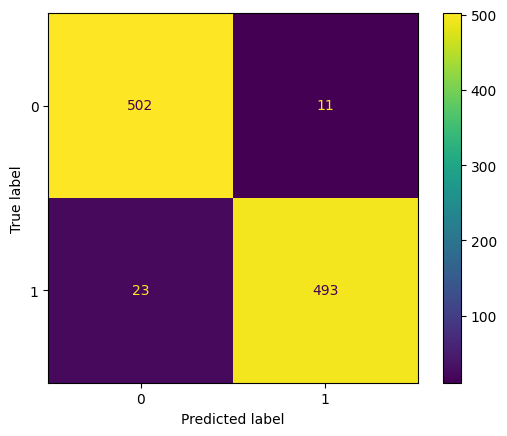

In [509]:
ConfusionMatrixDisplay(confusion_matrix(y_test.numpy(), c_test)).plot()



#####################################
>>> n channels = 1
#####################################


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1 train accuracy :  0.9701492537313433
1 test accuracy :  0.9591836734693877


#####################################
>>> n channels = 2
#####################################


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2 train accuracy :  0.9850746268656716
2 test accuracy :  0.966958211856171


#####################################
>>> n channels = 3
#####################################


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3 train accuracy :  0.9850746268656716
3 test accuracy :  0.9640427599611273


#####################################
>>> n channels = 4
#####################################


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4 train accuracy :  0.9850746268656716
4 test accuracy :  0.9620991253644315


#####################################
>>> n channels = 5
#####################################


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5 train accuracy :  0.9701492537313433
5 test accuracy :  0.9475218658892128


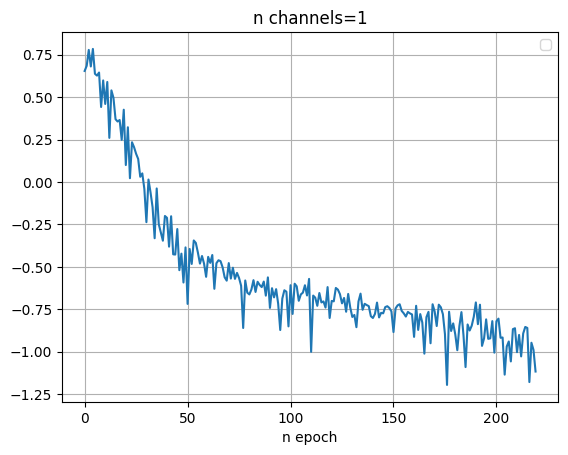

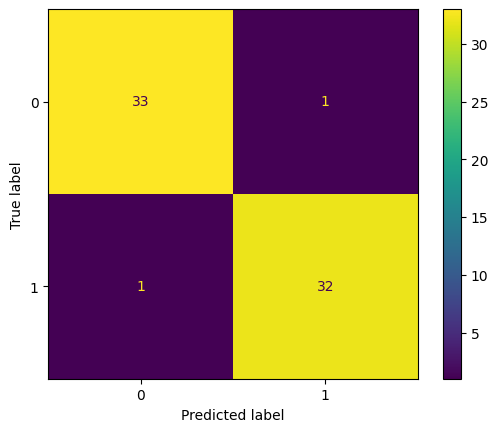

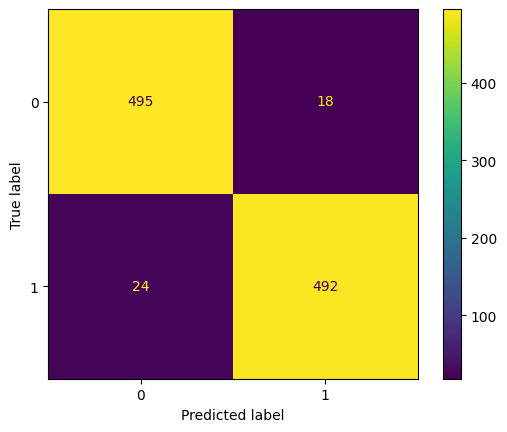

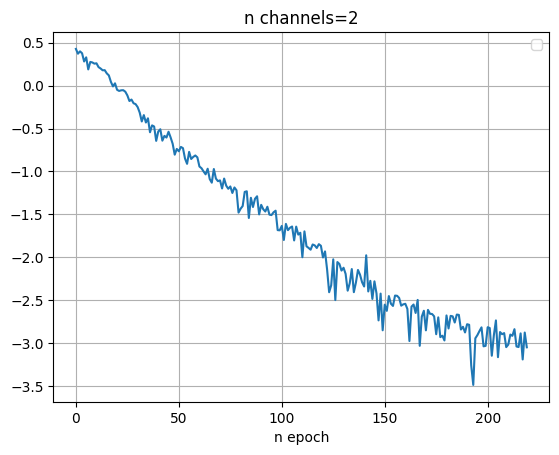

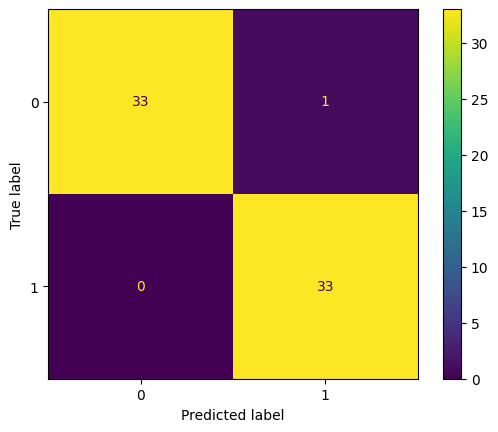

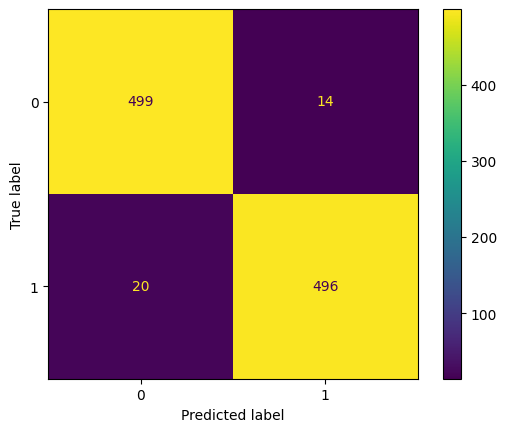

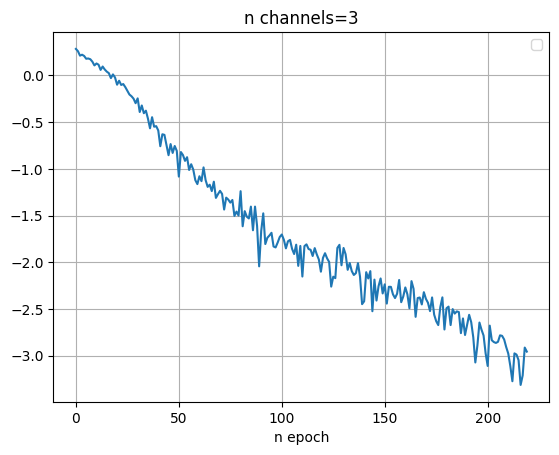

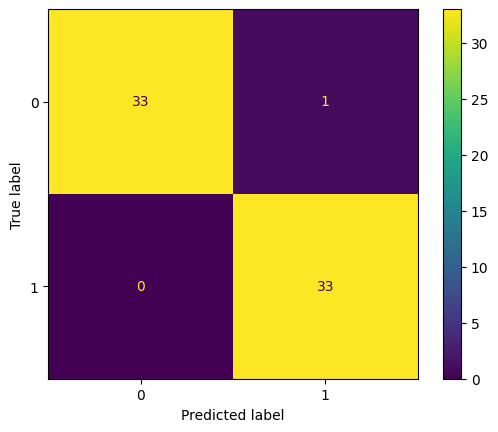

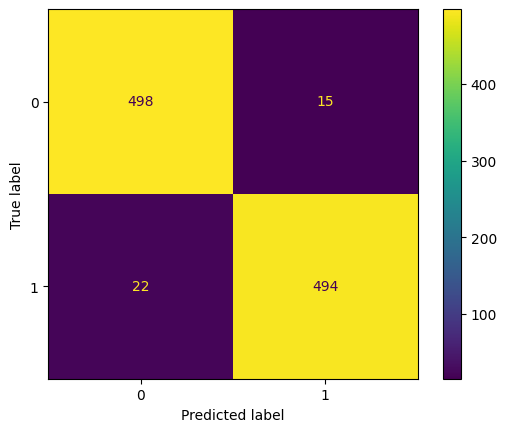

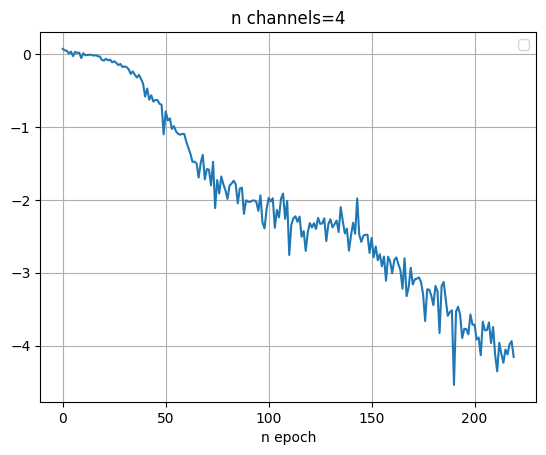

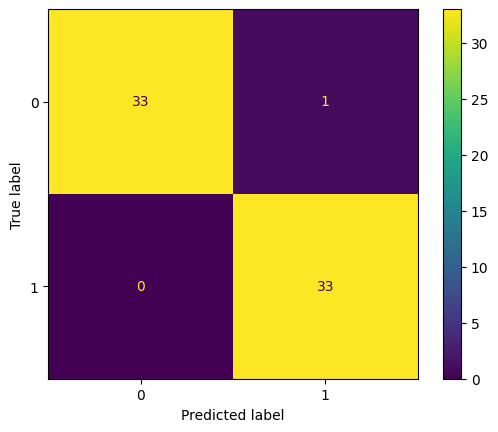

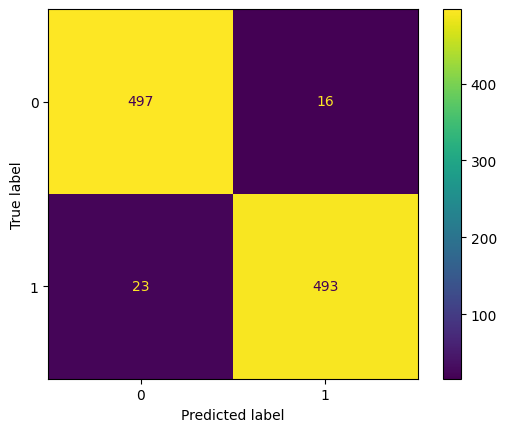

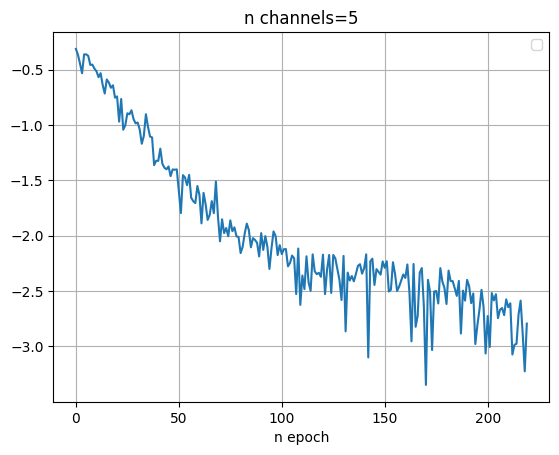

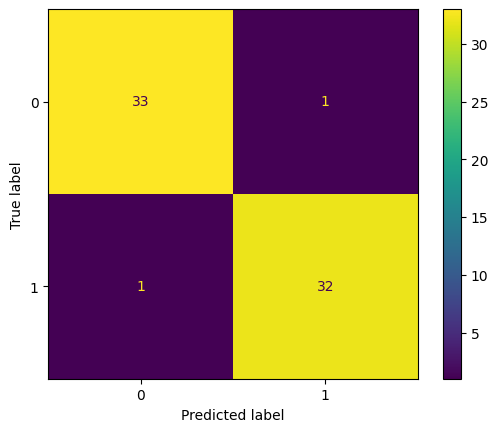

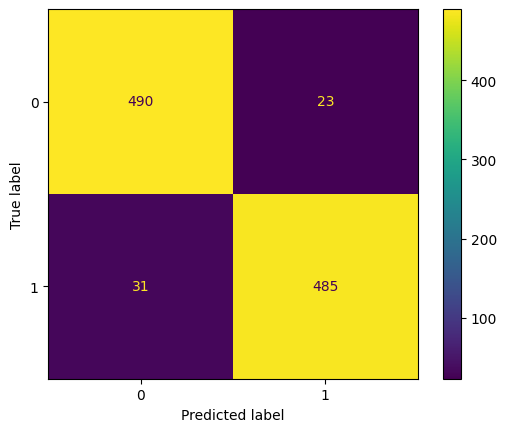

In [520]:
# try diferent sizes and groups and channels
hidden_size = 5
nchannelsx = range(1, 6)
res = pd.DataFrame(index=nchannelsx, columns=["Train", "Test"])
for nchannels in nchannelsx:
    print("\n")
    print("#####################################")
    print(f">>> n channels = {nchannels}")
    print("#####################################")
    dev_layer = development_layer(
        input_size=2,
        hidden_size=hidden_size,
        channels=nchannels,
        param=so,
        complexification=False,
        return_sequence=False,
    )
    optimizer = optim.Adam(dev_layer.parameters(), lr=0.0005)
    lossx = train_model_multichannels(
        dev_layer,
        optimizer,
        train_loader,
        hidden_size,
        num_epochs=220,
        verbose=False,
        alpha=0.5,
        beta=0.5,
    )
    _, ax = plt.subplots()
    ax.plot(range(len(lossx)), lossx)
    ax.set_title(f"n channels={nchannels}")
    ax.set_xlabel("n epoch")
    ax.legend()
    ax.grid()

    dev_train = dev_layer(tsx_train)
    dev_test = dev_layer(tsx_test)
    dt1 = dev_train[y_train == 1]
    dt2 = dev_train[y_train == 2]
    tau1 = torch.mean(dt1, axis=0)
    tau2 = torch.mean(dt2, axis=0)
    ddt1 = dt1 - tau1
    ddt2 = dt2 - tau2
    diff1 = (dev_train - tau1).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
    diff2 = (dev_train - tau2).reshape((len(y_train) * nchannels, hidden_size, hidden_size))

    dd1 = (
        torch.swapaxes(diff1, 1, 2)
        .bmm(diff1)
        .reshape((len(y_train), nchannels, hidden_size, hidden_size))
        .diagonal(dim1=2, dim2=3)
        .sum(-1)
        .sum(-1)
    )
    dd2 = (
        torch.swapaxes(diff2, 1, 2)
        .bmm(diff2)
        .reshape((len(y_train), nchannels, hidden_size, hidden_size))
        .diagonal(dim1=2, dim2=3)
        .sum(-1)
        .sum(-1)
    )

    c = (dd1 > dd2).detach().numpy().astype(float) + 1
    actrain = (y_train == c).sum().numpy() / len(y_train)

    print(nchannels, "train accuracy : ", actrain)

    diff1 = (dev_test - tau1).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
    diff2 = (dev_test - tau2).reshape((len(y_test) * nchannels, hidden_size, hidden_size))

    dd1 = (
        torch.swapaxes(diff1, 1, 2)
        .bmm(diff1)
        .reshape((len(y_test), nchannels, hidden_size, hidden_size))
        .diagonal(dim1=2, dim2=3)
        .sum(-1)
        .sum(-1)
    )
    dd2 = (
        torch.swapaxes(diff2, 1, 2)
        .bmm(diff2)
        .reshape((len(y_test), nchannels, hidden_size, hidden_size))
        .diagonal(dim1=2, dim2=3)
        .sum(-1)
        .sum(-1)
    )

    c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
    actest = (y_test.numpy() == c_test).sum() / len(y_test)
    print(nchannels, "test accuracy : ", actest)

    ConfusionMatrixDisplay(confusion_matrix(y_train.numpy(), c)).plot()

    res.loc[nchannels] = [actrain, actest]

    ConfusionMatrixDisplay(confusion_matrix(y_test.numpy(), c_test)).plot()

In [522]:
res.astype(float).round(3) * 100

,Train,Test
1,97.0,95.9
2,98.5,96.7
3,98.5,96.4
4,98.5,96.2
5,97.0,94.8


In [523]:
len(y_test)

1029